In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [6]:
class CalibModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=30, kernel_size=3, stride=1),
            nn.ELU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, stride=1),
            nn.ELU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, stride=1),
            nn.ELU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=1),
            nn.ELU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(10560, 2640),
            nn.ELU(),
            nn.Linear(2640, 512),
            nn.ELU(),
            nn.Linear(512, 2),
        )

    def forward(self,x):
        x = self.convs(x)
         #flatten
        x = self.classifier(x)
        return x

In [39]:
class Net (nn.Module):
    def __init__(self):
        super().__init__()
        self.model = CalibModel()
        self.model.load_state_dict(torch.load('../model.pt'))
        self.model.eval()
        self.convs = self.model.convs[:-1]
        self.maxpool = nn.MaxPool2d(2,2)
        self.classifier = self.model.classifier
        
        
    def conv_grad_hook(self,grad):
        self.grad = grad
        
        
    def forward(self,x):
        x = self.convs(x)
        x.register_hook(self.conv_grad_hook)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [24]:
img = '../data/videos/0/frame_18.png'

In [25]:
from PIL import Image

img = Image.open(img)

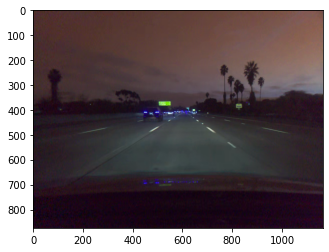

In [26]:
import numpy as np
plt.imshow(np.asarray(img))

In [45]:
from torchvision.transforms import transforms

In [46]:
transforms = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((218,291)),
        transforms.ToTensor(),
        transforms.Normalize(0.2311, 0.1354),
    ])

In [47]:
x = transforms(img)

In [48]:
x.shape

torch.Size([1, 218, 291])

In [40]:
net = Net()

In [49]:
pred = net(x.unsqueeze(0))

In [51]:
print(pred) #note that the output is normalized with the mean and std of the pitch and yaw in the dataset

tensor([[ 0.0287, -0.3078]], grad_fn=<AddmmBackward>)


In [53]:
pred[:, 0].backward()

In [54]:
gradients = net.grad

In [55]:
gradients.shape

torch.Size([1, 60, 23, 32])

In [56]:
channel_mean_gradients = gradients.mean(axis=(0, 2, 3))

In [57]:
channel_mean_gradients.shape

torch.Size([60])

In [77]:
last_conv_feautre_map = net.convs(x.unsqueeze(0))

In [78]:
last_conv_feautre_map = last_conv_feautre_map.detach()

In [79]:
print(last_conv_feautre_map.shape)

torch.Size([1, 60, 23, 32])


In [82]:
for i in range(60):
    last_conv_feautre_map[:, i, :, :] *= channel_mean_gradients[i]

In [83]:
heatmap = torch.mean(last_conv_feautre_map, dim=1).squeeze()

In [84]:
heatmap.shape

torch.Size([23, 32])

In [86]:
heatmap = heatmap.clip(0)

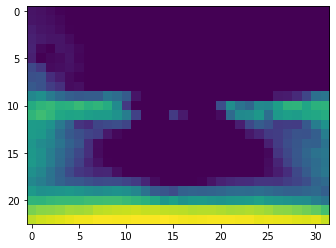

In [87]:
plt.imshow(heatmap)

In [88]:
#normalize map between zero and one

heatmap = (heatmap - heatmap.min())/ (heatmap.max()-heatmap.min())

In [105]:
import cv2 

heatmap_resized = cv2.resize(heatmap.numpy(), np.asarray(img).shape[:2][::-1])

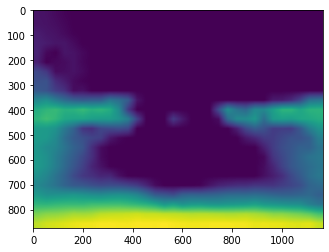

In [106]:
plt.imshow(heatmap_resized)

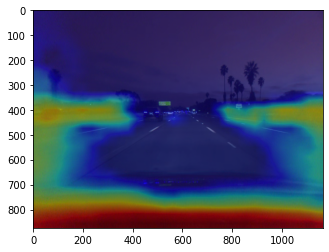

In [107]:
plt.imshow(np.asarray(img))
plt.imshow(heatmap_resized, cmap='jet', alpha=.5)

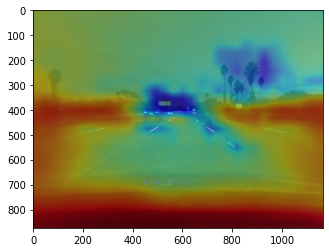

In [110]:
## perform the gradcam for yaw prediction also

net.zero_grad()

pred = net(x.unsqueeze(0))

pred[:, 1].backward()

gradients = net.grad

last_conv_feautre_map = net.convs(x.unsqueeze(0))

last_conv_feautre_map = last_conv_feautre_map.detach()

# Multiply the feature map by the gradients thereby weighing the feature map

for i in range(60):
    last_conv_feautre_map[:, i, :, :] *= channel_mean_gradients[i]
    
# generate heatmap by averaging across the `channels` axis... as the map is of shape (batch_size, #maps, h, w)
heatmap = torch.mean(last_conv_feautre_map, dim=1).squeeze()

#normalize map between zero and one
heatmap = (heatmap - heatmap.min())/ (heatmap.max()-heatmap.min())

# resize the heatmap to the size of the image, flipping the image dimensions because opencv resizes the image weird otherwise
heatmap_resized = cv2.resize(heatmap.numpy(), np.asarray(img).shape[:2][::-1])


plt.imshow(np.asarray(img))
plt.imshow(heatmap_resized, cmap='jet', alpha=.5)